# 日本とメッシュ

In the US, space is divided by "census tracts," a division created by the census bureau based on population counts. Census tract boundaries change every 10 years, making it difficult to measure change over time.

In contrast, Japan uses "meshes" which is a grid-based division of space. Population statistics are summarized by these meshes, which scale depending on the level of geography you are studying.

米国では、空間は「国勢調査区」によって分割されており、これは国勢調査局が人口数に基づいて作成した区画です。 国勢調査区域の境界は 10 年ごとに変化するため、時間の経過に伴う変化を測定することが困難になります。

対照的に、日本ではグリッドベースの空間分割である「メッシュ」が使用されます。 人口統計はこれらのメッシュによって要約され、調査している地理のレベルに応じてスケールが変わります。

<img src="https://www.stat.go.jp/data/mesh/img/map1.jpg">

[Figure about shows how grids are laid out in metropolitan Tokyo region. Source:総務省統計局](https://www.stat.go.jp/data/mesh/teiky_3.html)

## そもそもメッシュとは？


<img src="https://raw.githubusercontent.com/yohman/23-1-Reitaku-GIS/main/Weeks/Week10/images/japan%20mesh%20scales.png" width=800>

メッシュがどのように機能するかを理解するには、インタラクティブな Web マップでメッシュを体験するのが最善です。 国土地理院は、メッシュのオン/オフを切り替えるオプションを備えたインタラクティブなマップを提供しています。

➡️ [地理院地図](https://maps.gsi.go.jp/#5/36.104611/140.084556/&base=std&ls=std&disp=1&vs=c1g1j0h0k0l0u0t0z0r0s0m0f1)

➡️ ⚙️設定

➡️ グリッド表示

➡️ 地域メッシュ🔛

# メッシュでマップ

日本のメッシュがどのように機能するかを新たに理解したら、都道府県の人口マップを作成してみましょう。 1kmメッシュグリッドを使用します。 ワークフローは次のとおりです。

1. eStat Web サイトから、千葉県の 1km メッシュ グリッド (4 つ) を検索してダウンロード
2. 同じ Web サイトから、同じ地域とメッシュ サイズの人口統計をダウンロード
3. データをインポートして結合します。 これをメッシュと統計データの両方に対して行う
4. データのクリーンアップ。 これを避けることはできないステップである😕
5. 統計データをメッシュ データに結合する
6. 美しい地図を作成！

## Libraries

In [2]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import plotly.express as px
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt

# set font
import matplotlib as mpl

# for Mac
mpl.rc('font',family='Hiragino Maru Gothic Pro')

# for PC
# mpl.rc('font',family='MS Gothic')


## eStat Web サイトから、千葉県の 1km メッシュ グリッド (4 つ) を検索してダウンロード

➡️ https://www.e-stat.go.jp/

➡️ 地図

➡️ 統計データダウンロード

➡️ 境界データ

➡️ 3次メッシュ（1kmメッシュ）

➡️ 世界測地系緯度経度・Shapefile

➡️ 都道府県で絞込み

➡️ 12 千葉県 (チェック)

➡️ M5239, M5240, M5339, M5340 をそれぞれダウンロード

➡️ 新しいフォルダー【data】を作成

➡️ ダウンロードしたファイル[SDDSW5239.zip, SDDSW5240.zip, SDDSW5339.zip, SDDSW5340.zip,]を data フォルダーに移動

In [4]:
# 空間データなので geopandas (gpd) でインポート

chibamesh1 = gpd.read_file('data/SDDSWS5239/MESH05239.shp')
chibamesh2 = gpd.read_file('data/SDDSWS5240/MESH05240.shp')
chibamesh3 = gpd.read_file('data/SDDSWS5339/MESH05339.shp')
chibamesh4 = gpd.read_file('data/SDDSWS5340/MESH05340.shp')


### 四つのファイルを統合する

<img src="https://raw.githubusercontent.com/yohman/23-1-Reitaku-GIS/main/Weeks/Week10/images/chibamesh.png" width=600>

4つのメッシュgeodataが揃った。では統合しましょう。空間データを統合するには geopandas の `gpd.pd.concat()` 関数を使う。

In [5]:
# combine all four mesh shapes
chibamesh = gpd.pd.concat([chibamesh1,chibamesh2,chibamesh3,chibamesh4])

<Axes: >

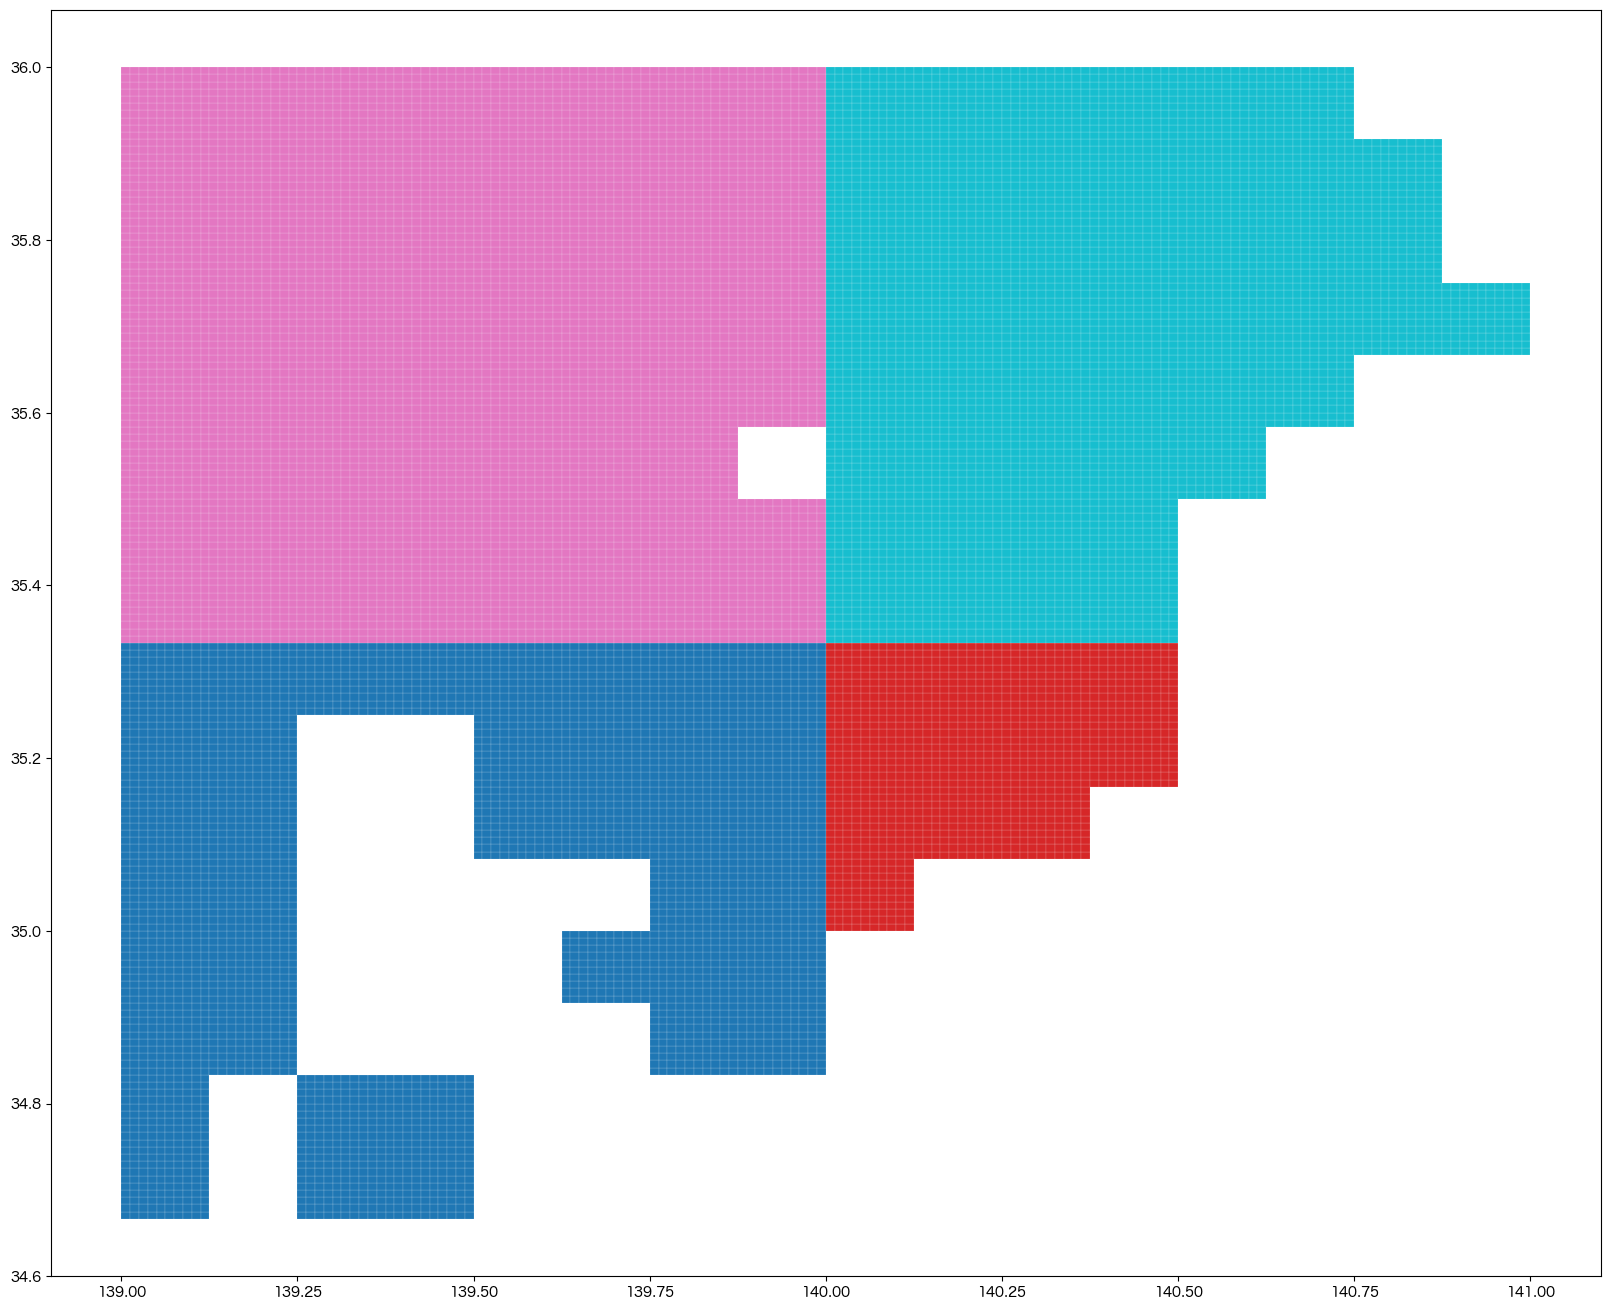

In [6]:
# quick plot
chibamesh.plot(figsize=(20,20),edgecolor='white',linewidth=0.1,column='MESH1_ID')

In [8]:
chibamesh.head()

,KEY_CODE,MESH1_ID,MESH2_ID,MESH3_ID,OBJ_ID,geometry
0,52390000,5239,00,00,1,"POLYGON ((139.01250 34.66667, 139.00000 34.666..."
1,52390001,5239,00,01,2,"POLYGON ((139.02500 34.66667, 139.01250 34.666..."
2,52390002,5239,00,02,3,"POLYGON ((139.03750 34.66667, 139.02500 34.666..."
3,52390003,5239,00,03,4,"POLYGON ((139.05000 34.66667, 139.03750 34.666..."
4,52390004,5239,00,04,5,"POLYGON ((139.06250 34.66667, 139.05000 34.666..."


## 人口統計をダウンロード

では４つのメッシュ（5339,5340,5239,5240) に当てはまる人口統計データをダウンロードしましょう。

➡️ https://www.e-stat.go.jp/

➡️ 地図

➡️ 統計データダウンロード

➡️ 統計データ

➡️ 国勢調査

➡️ 2020年

➡️ 3次メッシュ（1kmメッシュ）

➡️ 人口及び世帯

➡️ メッシュコードで絞込み（左欄）

➡️ M5239, M5240, M5339, M5340 をそれぞれチェックして選択ボタン

➡️ 定義書（PDF)をダウンロード（大事）

➡️ それぞれのCSVファイルをダウンロード

➡️ ダウンロードしたファイル[tblT001100S5239.zip, tblT001100S5240.zip, tblT001100S5339.zip, tblT001100S5340.zip,]を data フォルダーに移動

前回は、ファイルを展開しなければいけないと思ったのですが、pandas は圧縮ファイルを読み込めることが判明したので、展開する必要はありません。

In [12]:
# csvデータなので pandas (pd) でインポート
# 文字化け予防のために encoding='cp932' 
chibadata1 = pd.read_csv('data/tblT001100S5239.txt', encoding='cp932')
chibadata4 = pd.read_csv('data/tblT001100S5340.txt', encoding='cp932')
chibadata2 = pd.read_csv('data/tblT001100S5240.txt', encoding='cp932')
chibadata3 = pd.read_csv('data/tblT001100S5339.txt', encoding='cp932')

### 定義書を確認

<img src="https://raw.githubusercontent.com/yohman/23-1-Reitaku-GIS/main/Weeks/Week10/images/metadata.png">

「連番」列は、ダウンロードしたデータに存在するフィールド名を示します。 これらのフィールド名は、その変数のコロプレス マップを作成するために使用されます。

## Data cleanup

In [13]:
# check data
chibadata4.head()

,KEY_CODE,HTKSYORI,HTKSAKI,GASSAN,T001100001,T001100002,T001100003,T001100004,T001100005,T001100006,...,T001100041,T001100042,T001100043,T001100044,T001100045,T001100046,T001100047,T001100048,T001100049,T001100050
0,NaN,NaN,NaN,NaN,人口（総数）,人口（総数） 男,人口（総数） 女,０～１４歳人口 総数,０～１４歳人口 男,０～１４歳人口 女,...,６人世帯数 一般世帯数,７人以上世帯数 一般世帯数,親族のみの世帯数 一般世帯数,核家族世帯数 一般世帯数,核家族以外の世帯数 一般世帯数,６歳未満世帯員のいる世帯数 一般世帯数,６５歳以上世帯員のいる世帯数 一般世帯数,世帯主の年齢が２０～２９歳の１人世帯数 一般世帯数,高齢単身世帯数 一般世帯数,高齢夫婦世帯数 一般世帯数
1,53400000.0,1.0,NaN,53400010,67,36,31,7,5,2,...,2,1,19,13,6,2,14,0,3,3
2,53400001.0,0.0,NaN,NaN,9,4,5,0,0,0,...,0,0,4,4,0,0,2,0,0,0
3,53400002.0,0.0,NaN,NaN,168,85,83,8,3,5,...,1,1,51,34,17,1,44,0,7,10
4,53400003.0,0.0,NaN,NaN,267,129,138,21,8,13,...,3,2,78,55,23,4,70,1,11,19


このデータには 2 つの問題があります。

まず、最初の行には説明テキストが含まれている（人口（総数）など）。 これは、列を数値にする必要がある統計マップを作成する場合に問題を引き起こします。

次に、データに「*」が含まれている。 これも数字以外の文字であるため、問題が発生します。

これらに一つ一つ対処していく必要がある。

### 問題１：１行目を削除
さ、ここで課題です。４つのテーブルから１行目を削除してください。Googleで検索したり、ChatGPTに相談したり、隣の人と話してもオッケー！

In [14]:
# ４つのテーブルから１行目を削除
chibadata1 = chibadata1[1:]

In [16]:
# ４つのテーブルから１行目を削除
chibadata2 = chibadata2[1:]
chibadata3 = chibadata3[1:]
chibadata4 = chibadata4[1:]

In [17]:
# ４つのテーブルから１行目を削除


### 問題２：「＊」を NaN に置き換え

2番目の問題は四つのデータテーブルに「＊」の文字が入っているので、これを全て NaN (非数) に置き換える必要がある。自分で調べて実行してみよう。

Hint: `.replace()` 関数を使う

In [18]:
# ４つのテーブルから「＊」を非数に置き換える
chibadata1 = chibadata1.replace('*',np.nan)
chibadata2 = chibadata2.replace('*',np.nan)
chibadata3 = chibadata3.replace('*',np.nan)
chibadata4 = chibadata4.replace('*',np.nan)

In [ ]:
# ４つのテーブルから「＊」を非数に置き換える
chibadata1

## ４つのデータを統合

クリーンアップされた４つの統計データを一つに統合しよう。これはCSVデータなので pandas の `pd.concat()` 関数を使う。

In [19]:
chibadata = pd.concat([chibadata1,chibadata2,chibadata3,chibadata4])

In [20]:
# check data info
chibadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10357 entries, 1 to 3623
Data columns (total 54 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   KEY_CODE    10357 non-null  float64
 1   HTKSYORI    10357 non-null  float64
 2   HTKSAKI     475 non-null    float64
 3   GASSAN      405 non-null    object 
 4   T001100001  10357 non-null  object 
 5   T001100002  10357 non-null  object 
 6   T001100003  10357 non-null  object 
 7   T001100004  9882 non-null   object 
 8   T001100005  9882 non-null   object 
 9   T001100006  9882 non-null   object 
 10  T001100007  9882 non-null   object 
 11  T001100008  9882 non-null   object 
 12  T001100009  9882 non-null   object 
 13  T001100010  9882 non-null   object 
 14  T001100011  9882 non-null   object 
 15  T001100012  9882 non-null   object 
 16  T001100013  9882 non-null   object 
 17  T001100014  9882 non-null   object 
 18  T001100015  9882 non-null   object 
 19  T001100016  9882 non-null   obj

おっと！ここでもうひとつ問題発見！データが全て「object」タイプだ！これを数値に変換する必要がある。

### データタイプ管理

データがobjectだと数値ではないのでマップもチャートも作れません。

このデータはカラムの数が多いので、ひとつひとつ変えて行くのは要領が悪いので、すべてのデータ型を一括で変更する方法を説明します。

In [21]:
# まずはカラムをアウトプット
chibadata.columns

Index(['KEY_CODE', 'HTKSYORI', 'HTKSAKI', 'GASSAN', 'T001100001', 'T001100002',
       'T001100003', 'T001100004', 'T001100005', 'T001100006', 'T001100007',
       'T001100008', 'T001100009', 'T001100010', 'T001100011', 'T001100012',
       'T001100013', 'T001100014', 'T001100015', 'T001100016', 'T001100017',
       'T001100018', 'T001100019', 'T001100020', 'T001100021', 'T001100022',
       'T001100023', 'T001100024', 'T001100025', 'T001100026', 'T001100027',
       'T001100028', 'T001100029', 'T001100030', 'T001100031', 'T001100032',
       'T001100033', 'T001100034', 'T001100035', 'T001100036', 'T001100037',
       'T001100038', 'T001100039', 'T001100040', 'T001100041', 'T001100042',
       'T001100043', 'T001100044', 'T001100045', 'T001100046', 'T001100047',
       'T001100048', 'T001100049', 'T001100050'],
      dtype='object')

変換が必要なのは「T0011000」で始まる変数のみなので、このリストの4番目以降になる。

では4番目以降のカラムをアウトプットしよう。

In [22]:
# 4番目以降をアウトプット
chibadata.columns[4:]

Index(['T001100001', 'T001100002', 'T001100003', 'T001100004', 'T001100005',
       'T001100006', 'T001100007', 'T001100008', 'T001100009', 'T001100010',
       'T001100011', 'T001100012', 'T001100013', 'T001100014', 'T001100015',
       'T001100016', 'T001100017', 'T001100018', 'T001100019', 'T001100020',
       'T001100021', 'T001100022', 'T001100023', 'T001100024', 'T001100025',
       'T001100026', 'T001100027', 'T001100028', 'T001100029', 'T001100030',
       'T001100031', 'T001100032', 'T001100033', 'T001100034', 'T001100035',
       'T001100036', 'T001100037', 'T001100038', 'T001100039', 'T001100040',
       'T001100041', 'T001100042', 'T001100043', 'T001100044', 'T001100045',
       'T001100046', 'T001100047', 'T001100048', 'T001100049', 'T001100050'],
      dtype='object')

In [23]:
# このカラムをテーブル形式で見る
chibadata[chibadata.columns[4:]]

,T001100001,T001100002,T001100003,T001100004,T001100005,T001100006,T001100007,T001100008,T001100009,T001100010,...,T001100041,T001100042,T001100043,T001100044,T001100045,T001100046,T001100047,T001100048,T001100049,T001100050
1,4,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,6,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14,7,7,0,0,0,26,14,12,19,...,0,0,6,6,0,0,6,4,3,1
4,3,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,13,11,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,1008,508,500,204,94,110,790,404,386,601,...,7,6,276,234,42,66,129,4,25,33
3620,332,173,159,43,19,24,289,154,135,180,...,5,4,86,58,28,12,72,2,18,11
3621,194,100,94,18,13,5,175,87,88,115,...,3,0,55,39,16,3,36,1,5,7
3622,508,245,263,103,44,59,405,201,204,274,...,6,5,148,127,21,27,88,0,13,33


では一気にobjectからfloatに変換してみよう！

In [24]:
# objectからfloatに変換
chibadata[chibadata.columns[4:]].astype(float)

,T001100001,T001100002,T001100003,T001100004,T001100005,T001100006,T001100007,T001100008,T001100009,T001100010,...,T001100041,T001100042,T001100043,T001100044,T001100045,T001100046,T001100047,T001100048,T001100049,T001100050
1,4.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9.0,6.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14.0,7.0,7.0,0.0,0.0,0.0,26.0,14.0,12.0,19.0,...,0.0,0.0,6.0,6.0,0.0,0.0,6.0,4.0,3.0,1.0
4,3.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,13.0,11.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,1008.0,508.0,500.0,204.0,94.0,110.0,790.0,404.0,386.0,601.0,...,7.0,6.0,276.0,234.0,42.0,66.0,129.0,4.0,25.0,33.0
3620,332.0,173.0,159.0,43.0,19.0,24.0,289.0,154.0,135.0,180.0,...,5.0,4.0,86.0,58.0,28.0,12.0,72.0,2.0,18.0,11.0
3621,194.0,100.0,94.0,18.0,13.0,5.0,175.0,87.0,88.0,115.0,...,3.0,0.0,55.0,39.0,16.0,3.0,36.0,1.0,5.0,7.0
3622,508.0,245.0,263.0,103.0,44.0,59.0,405.0,201.0,204.0,274.0,...,6.0,5.0,148.0,127.0,21.0,27.0,88.0,0.0,13.0,33.0


いよいよ、元のデータと新しく変換したデータを入れ替える。ここで大事なのは元のデータの4番目以降だけを入れ替えること。

In [25]:
# 元のデータを入れ替える
chibadata[chibadata.columns[4:]]=chibadata[chibadata.columns[4:]].astype(float)

さ、必ずうまく行ったかどうかをチェックする。objectがfloatに変わってたら成功！

In [26]:
# check!
chibadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10357 entries, 1 to 3623
Data columns (total 54 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   KEY_CODE    10357 non-null  float64
 1   HTKSYORI    10357 non-null  float64
 2   HTKSAKI     475 non-null    float64
 3   GASSAN      405 non-null    object 
 4   T001100001  10357 non-null  float64
 5   T001100002  10357 non-null  float64
 6   T001100003  10357 non-null  float64
 7   T001100004  9882 non-null   float64
 8   T001100005  9882 non-null   float64
 9   T001100006  9882 non-null   float64
 10  T001100007  9882 non-null   float64
 11  T001100008  9882 non-null   float64
 12  T001100009  9882 non-null   float64
 13  T001100010  9882 non-null   float64
 14  T001100011  9882 non-null   float64
 15  T001100012  9882 non-null   float64
 16  T001100013  9882 non-null   float64
 17  T001100014  9882 non-null   float64
 18  T001100015  9882 non-null   float64
 19  T001100016  9882 non-null   flo

## Join Mesh with Data

ついに、結合されたメッシュ データ (chibamesh) と結合されたデータフレーム (chibadata) が完成しました。 最後のステップは、chibadata を chibamesh geodataframe に結合することです。

これを行うには、それらを KEY_CODE id 列で結合します。 ただし、chibamesh KEY_CODE 列はオブジェクトであることに注意してください。 まずこれを float に変換しましょう。

In [27]:
# KEY_CODEをfloatに
chibamesh['KEY_CODE']=chibamesh['KEY_CODE'].astype(float)

マージを実行する！

In [28]:
# merge the data
chibamesh = chibamesh.merge(chibadata, on='KEY_CODE')

In [29]:
# check!
chibamesh.sample(5)

,KEY_CODE,MESH1_ID,MESH2_ID,MESH3_ID,OBJ_ID,geometry,HTKSYORI,HTKSAKI,GASSAN,T001100001,...,T001100041,T001100042,T001100043,T001100044,T001100045,T001100046,T001100047,T001100048,T001100049,T001100050
4248,53394326.0,5339,43,26,3427,"POLYGON ((139.46250 35.68333, 139.45000 35.683...",0.0,NaN,NaN,10059.0,...,26.0,4.0,2900.0,2733.0,167.0,301.0,2000.0,158.0,665.0,614.0
2978,53392082.0,5339,20,82,1683,"POLYGON ((139.03750 35.56667, 139.02500 35.566...",0.0,NaN,NaN,93.0,...,0.0,0.0,29.0,22.0,7.0,0.0,28.0,0.0,4.0,6.0
7524,53402247.0,5340,22,47,1048,"POLYGON ((140.35000 35.53333, 140.33750 35.533...",0.0,NaN,NaN,328.0,...,4.0,1.0,100.0,86.0,14.0,8.0,75.0,1.0,16.0,21.0
10025,53407177.0,5340,71,77,4278,"POLYGON ((140.22500 35.97500, 140.21250 35.975...",0.0,NaN,NaN,90.0,...,2.0,0.0,23.0,14.0,9.0,4.0,26.0,0.0,9.0,4.0
9961,53407112.0,5340,71,12,4213,"POLYGON ((140.16250 35.92500, 140.15000 35.925...",0.0,NaN,NaN,1617.0,...,4.0,0.0,524.0,496.0,28.0,74.0,287.0,23.0,58.0,129.0


## Map time

As you can see, creating a map is no easy feat. Data is almost always in need to be prepared, cleaned-up, and modified to make it "map-ready." This process is called "data-wrangling," and it represents an inevitable, yet extremely valuable skill in making legitimate and informative maps.

Before we begin the mapping process, remember that your data needs to be reprojected to web mercator, which has a crs code of 3867. This is necessary in order to make your data compatible with the basemaps that are made available by the contextily library. 

ご覧のとおり、マップの作成は簡単ではありません。 データは、ほとんどの場合、「マップ対応」にするために準備、クリーンアップ、および変更する必要があります。 このプロセスは「データラングリング」と呼ばれ、正当で有益な地図を作成する上で避けられないものの、非常に貴重なスキルを表します。


### Project the data
マッピング プロセスを開始する前に、データを Web メルカトルに再投影する必要があることに注意してください。Web メルカトルの crs コードは 3867 です。これは、データを contextily ライブラリで利用できるベースマップと互換性を持たせるために必要です。

In [30]:
# reproject to 3857 (web mercator)
chibamesh = chibamesh.to_crs(3857)

<Axes: >

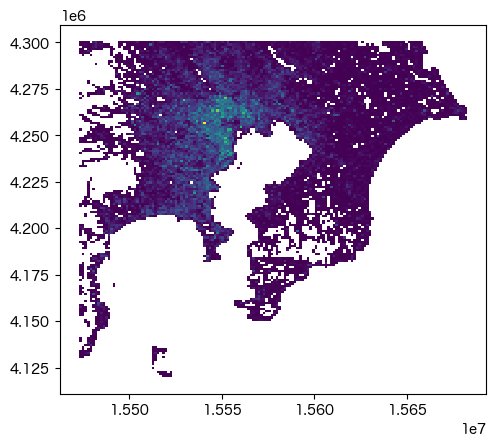

In [31]:
# make a quick plot
chibamesh.plot(column='T001100030')

### 問題３：マップストーリーを作成

メタデータを参照して、「ストーリーを伝える」一連の (4 つ以上の) コロプレス マップを作成します。 前週のラボ (Week09.ipynb) で使用した方法を使用してマップを作成します。

要件：
- タイトル
- 伝説
- ベースマップ
- 各マップのストーリーを説明するマークダウン セル
- 作成したマップをクラスギャラリーの[Googleスライド](https://docs.google.com/presentation/d/1oIwXESVpEQOlATKbUgNOGgSbz1IV63mDehEfBzGdDn0/edit#slide=id.g22aa073ab07_0_54)に追加

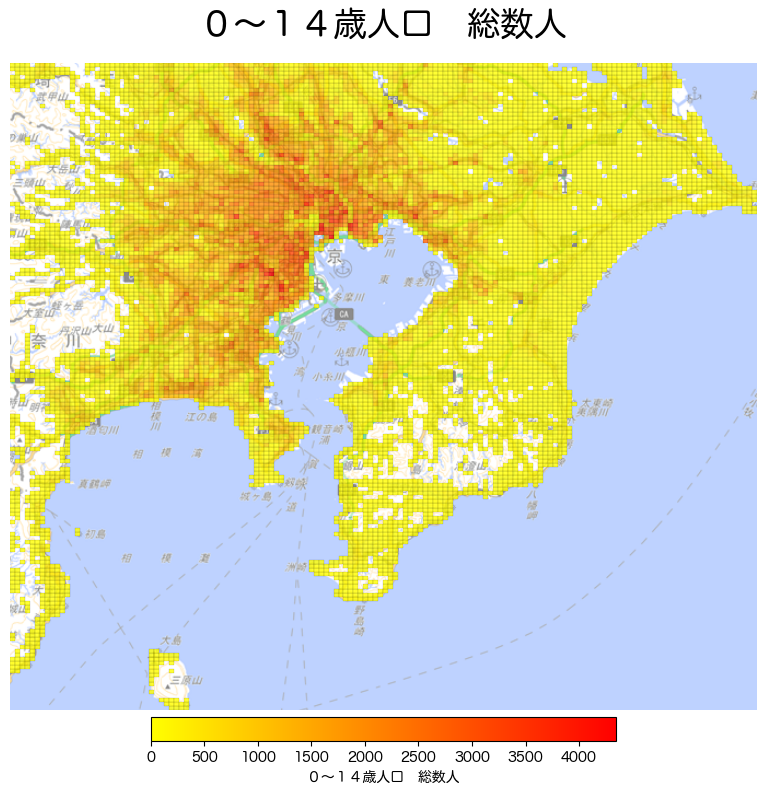

In [32]:
# 人口マップ
fig, ax = plt.subplots(figsize=(10,10))

chibamesh.plot(ax=ax,
         column='T001100004',
         legend=True,
         cmap='autumn_r',
         edgecolor='black',
         linewidth=0.1,
         alpha=0.8,
        #  vmax=3000,
         legend_kwds={'label': "０～１４歳人口　総数人",'shrink': 0.6, 'orientation': "horizontal", 'pad': 0.01}
)

# マップの範囲を chibamesh の境界に設定
ax.set_xlim(chibamesh.total_bounds[0], chibamesh.total_bounds[2])
ax.set_ylim(chibamesh.total_bounds[1], chibamesh.total_bounds[3])

# 軸を非表示にする
ax.axis('off')

# タイトル
ax.set_title('０～１４歳人口　総数人',fontsize=24,pad=20);

# ベースマップを追加
cx.add_basemap(ax,source='https://cyberjapandata.gsi.go.jp/xyz/pale/{z}/{x}/{y}.png')

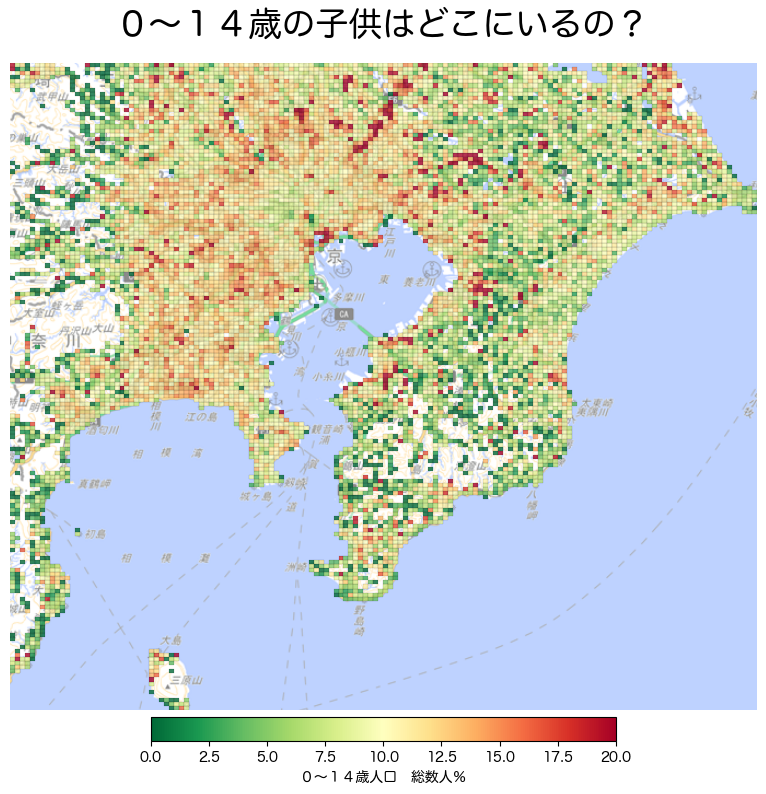

In [33]:
# 正規化された値を計算する
chibamesh['Percent0_14'] = chibamesh['T001100004'] / chibamesh['T001100001']*100

# コロプレスマップをプロットする
fig, ax = plt.subplots(figsize=(10, 10))

chibamesh.plot(ax=ax,
               column='Percent0_14',
               legend=True,
               cmap='RdYlGn_r',
               edgecolor='black',
               linewidth=0.1,
               alpha=0.8,
               vmax=20,
               legend_kwds={'label': '０～１４歳人口　総数人％', 'shrink': 0.6, 'orientation': 'horizontal', 'pad': 0.01}
              )

# マップの範囲を chibamesh の境界に設定する
ax.set_xlim(chibamesh.total_bounds[0], chibamesh.total_bounds[2])
ax.set_ylim(chibamesh.total_bounds[1], chibamesh.total_bounds[3])

# 軸を非表示にする
ax.axis('off')

# タイトルを設定する
ax.set_title('０～１４歳の子供はどこにいるの？', fontsize=24, pad=20)

# ベースマップを追加する
cx.add_basemap(ax, source='https://cyberjapandata.gsi.go.jp/xyz/pale/{z}/{x}/{y}.png')

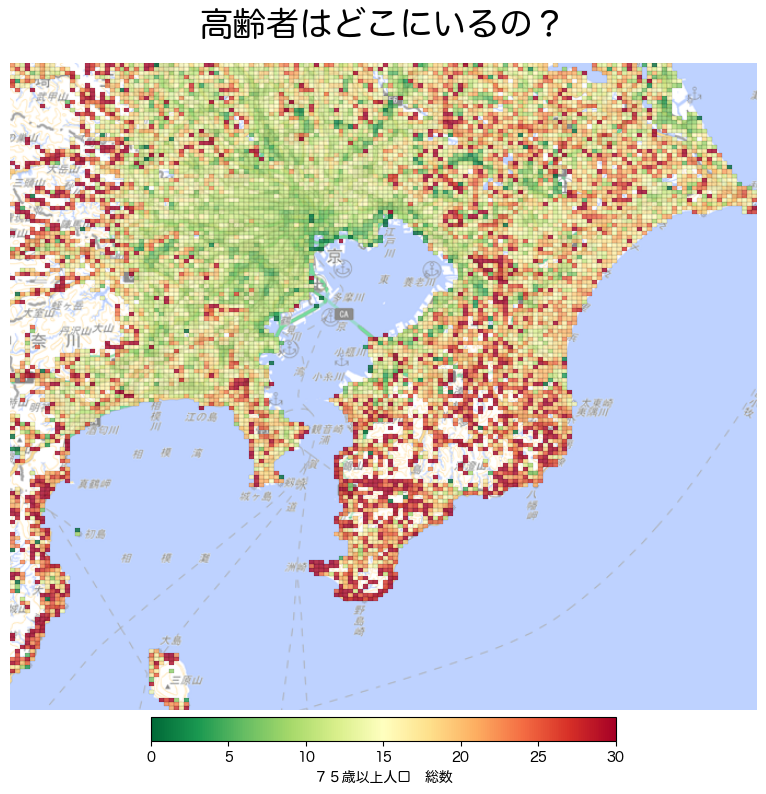

In [34]:
# 正規化された値を計算する
chibamesh['Percent75over'] = chibamesh['T001100022'] / chibamesh['T001100001']*100

# コロプレスマップをプロットする
fig, ax = plt.subplots(figsize=(10, 10))

chibamesh.plot(ax=ax,
               column='Percent75over',
               legend=True,
               cmap='RdYlGn_r',
               edgecolor='black',
               linewidth=0.1,
               alpha=0.8,
               vmax=30,
               legend_kwds={'label': '７５歳以上人口　総数', 'shrink': 0.6, 'orientation': 'horizontal', 'pad': 0.01}
              )

# マップの範囲を chibamesh の境界に設定する
ax.set_xlim(chibamesh.total_bounds[0], chibamesh.total_bounds[2])
ax.set_ylim(chibamesh.total_bounds[1], chibamesh.total_bounds[3])

# 軸を非表示にする
ax.axis('off')

# タイトルを設定する
ax.set_title('高齢者はどこにいるの？', fontsize=24, pad=20)

# ベースマップを追加する
cx.add_basemap(ax, source='https://cyberjapandata.gsi.go.jp/xyz/pale/{z}/{x}/{y}.png')